# 11. Linear Regression

## 11.2 Least squares linear regression

### 11.2.1 Terminology

> Plot polynomial regression on 1d problem
> Based on https://github.com/probml/pmtk3/blob/master/demos/linregPolyVsDegree.m

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()

N = 21
X_train = np.linspace(0, 20, N)
X_test = np.arange(0, 20, 0.1)

sigma = 2
w = np.array([-1.5, 1 / 9.0])
fn = lambda x: w[0] * x + w[1] * np.square(x)
y_train = fn(X_train) + rng.normal(scale=sigma, size=X_train.shape)
y_test = fn(X_test) + rng.normal(scale=sigma, size=X_test.shape)

# Reshape for fitting
X_train = X_train.reshape((-1, 1))
X_test = X_test.reshape((-1, 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21, 1), (21,), (200, 1), (200,))

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

def least_squares_estimation(X_train, y_train, X_test, y_test, degree=1):
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    mse_train = mean_squared_error(y_train_pred, y_train)
    mse_test = mean_squared_error(y_test_pred, y_test)
    
    return (y_train_pred, mse_train), (y_test_pred, mse_test), \
           (model.intercept_, model.coef_[0])

pred_train, pred_test, theta = least_squares_estimation(
    X_train, y_train, X_test, y_test, degree=1
)
pred_train[0].shape, pred_train[1], pred_test[0].shape, pred_test[1], theta
    

((21,),
 16.659856638276,
 (200,),
 15.913773623004309,
 (-7.741017607903819, 0.835067704397991))

#### Figure 11.1: Polynomial of degree 1 and 2 fit to 21 datapoints.

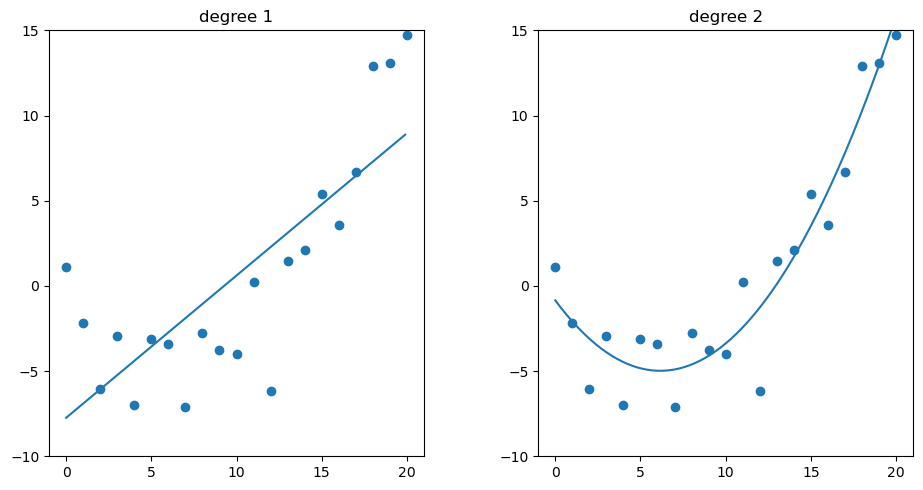

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# Plot fitted functions
for degree, ax in zip([1, 2], axes):
    ax.scatter(X_train, y_train)
    _, pred_test, _ = least_squares_estimation(
        X_train, y_train, X_test, y_test, degree=degree
    )
    ax.plot(X_test, pred_test[0])
    ax.set_ylim((-10, 15))
    ax.set_title(f'degree {degree}')
    ax.set_aspect('equal')

fig.tight_layout()

### 11.2.2 Least squares estimation

#### Figure 11.2: (a) Contours of the RSS error surface for the example in Figure 11.1 (a). The blue cross represnts the MLE. (b) Corresponding surface plot.

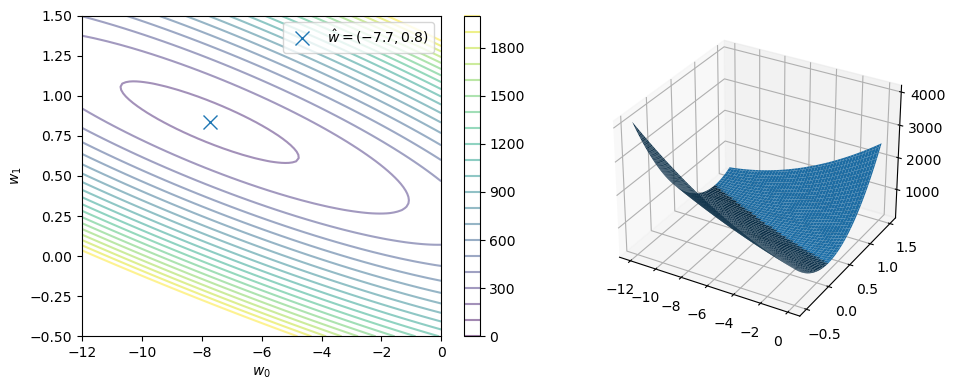

In [5]:
_, _, hat_w = least_squares_estimation(
    X_train, y_train, X_test, y_test, degree=1
)

xgrid = np.linspace(-12, 0, 100)
ygrid = np.linspace(-0.5, 1.5, 100)
W0, W1 = np.meshgrid(xgrid, ygrid)
RSS = (np.sum(
    (W0.ravel() + W1.ravel() * X_train - y_train.reshape((-1, 1))) ** 2,
    axis=0
) / 2).reshape(W0.shape)

fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.contour(W0, W1, RSS, levels=np.linspace(0, 2000, 21), alpha=0.5)
ax1.plot(
    *hat_w, marker='x', markersize=10, lw=0,
    label=f'$\\hat w=({hat_w[0]:.1f}, {hat_w[1]:.1f})$'
)
ax1.set_xlabel('$w_0$')
ax1.set_ylabel('$w_1$')
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax2.plot_surface(W0, W1, RSS)

fig.colorbar(cs, ax=ax1)
fig.tight_layout()

### 11.2.3 Other approaches to computing the MLE

#### 11.2.3.4 Recursively computing the MLE

#### Figure 11.4: Regression coefficients over time for the 1d model in Figure 11.1.

In [6]:
def linreg_update(X, y):
    assert ((X.ndim == 2 and X.shape[1] == 1) or X.ndim == 1) and y.ndim == 1
    if X.ndim == 2:
        X = X[:, 0]

    bar_x = X[0]
    bar_y = y[0]
    C_xx = C_xy = 0

    w = []
    n = 1
    for x_np1, y_np1 in zip(X[1:], y[1:]):
        bar_x_n = bar_x # old bar_x
        bar_y_n = bar_y # old bar_y
        np1 = n + 1
        # equation 11.33
        bar_x = bar_x_n + (x_np1 - bar_x_n) / np1
        bar_y = bar_y_n + (y_np1 - bar_y_n) / np1
        # equation 11.40
        C_xy = (x_np1 * y_np1 + n * C_xy + n * bar_x_n * bar_y_n - np1 * bar_x * bar_y) / np1
        C_xx = (x_np1 * x_np1 + n * C_xx + n * bar_x_n * bar_x_n - np1 * bar_x * bar_x) / np1
        # equation 11.27 and 11.28
        w1 = C_xy / C_xx
        w0 = bar_y - w1 * bar_x
        w.append([w0, w1, np1])
        n += 1
    return np.asarray(w)

w = linreg_update(X_train, y_train)
w.shape

(20, 3)

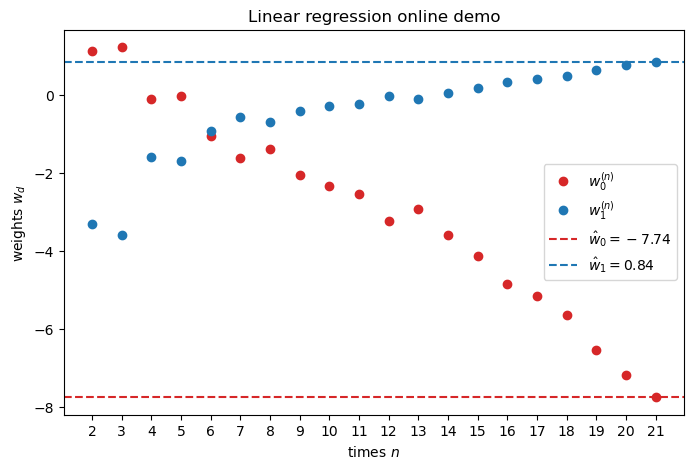

In [7]:
bar_x = X_train.mean()
bar_y = y_train.mean()
X_c = X_train[:, 0] - bar_x
y_c = y_train - bar_y
hat_w1 = np.dot(X_c, y_c) / np.sum(X_c ** 2) # eq 11.27
hat_w0 = bar_y - hat_w1 * bar_x              # eq 11.28

_, ax = plt.subplots(figsize=(8, 5))
ax.plot(w[:, 2], w[:, 0], color='tab:red', marker='o', ls='', label='$w_0^{(n)}$')
ax.plot(w[:, 2], w[:, 1], color='tab:blue', marker='o', ls='', label='$w_1^{(n)}$')
ax.axhline(hat_w0, color='tab:red', ls='--', label=f'$\hat w_0={hat_w0:.2f}$')
ax.axhline(hat_w1, color='tab:blue', ls='--', label=f'$\hat w_1={hat_w1:.2f}$')
ax.set_xticks(w[:, 2])
ax.set_xlabel('times $n$')
ax.set_ylabel('weights $w_d$')
ax.set_title('Linear regression online demo')
ax.legend();


### 11.2.4 Measuring goodness of fit

#### 11.2.4.1 Residual plots

#### Figure 11.5: Residual plot for polynomial regression of degree 1 and 2 for the functions in Figure 11.1.

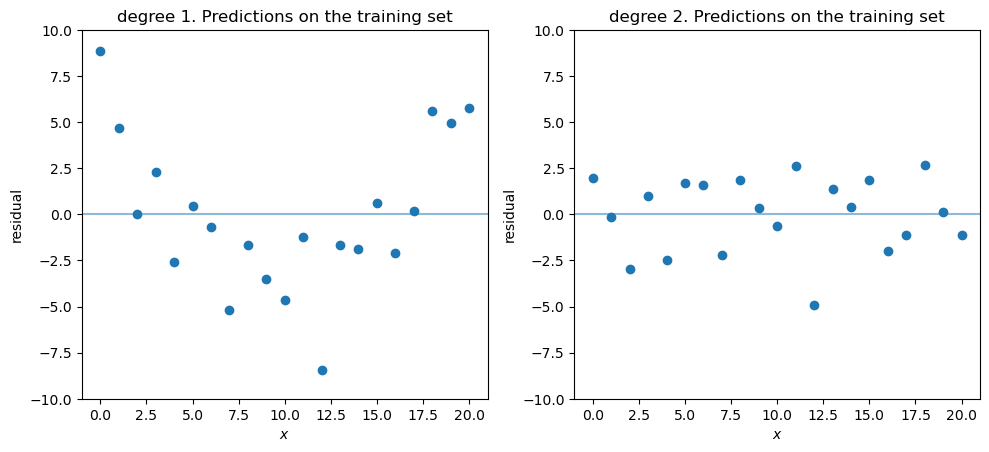

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# Plot residuals
for degree, ax in zip([1, 2], axes):
    pred_train, _, _ = least_squares_estimation(
        X_train, y_train, X_test, y_test, degree=degree
    )
    residuals = y_train - pred_train[0]
    ax.plot(X_train, residuals, 'o')
    ax.axhline(y=0, alpha=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('residual')
    ax.set_ylim(-10, 10)
    ax.set_title(f'degree {degree}. Predictions on the training set')
    ax.set_aspect('equal')

fig.tight_layout()

#### Figure 11.6: Fit vs. actual plots for polynomial regression of degree 1 and 2 for the functions in Figure 11.1.

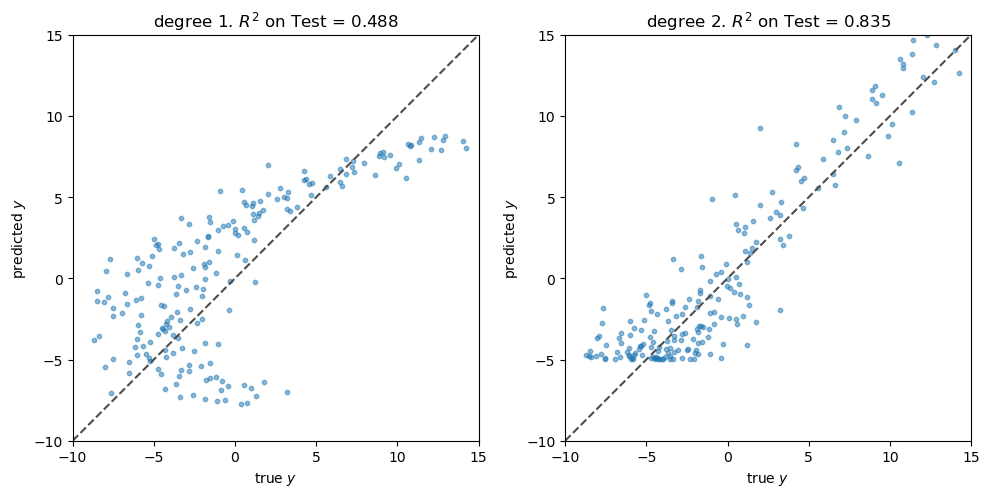

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# Plot fit vs actual
for degree, ax in zip([1, 2], axes):
    _, pred_test, _ = least_squares_estimation(
        X_train, y_train, X_test, y_test, degree=degree
    )
    ax.scatter(y_test, pred_test[0], s=10, alpha=0.5)
    ax.axline(xy1=(0, 0), slope=1, ls="--", c=".3")
    ax.set_xlabel('true $y$')
    ax.set_ylabel('predicted $y$')
    ax.set_xlim(-10, 15)
    ax.set_ylim(-10, 15)
    r2 = r2_score(y_test, pred_test[0])
    ax.set_title(f'degree {degree}. $R^2$ on Test = {r2:0.3f}')
    ax.set_aspect('equal')
        
fig.tight_layout()